<font size="3"> Исследование крупных рекамодателей по FTD </font>
<br> <a href="https://docs.google.com/spreadsheets/d/116EgRqQsMx7-RiwZfvOXSo1LjLLfJSp5/edit?gid=1975523515#gid=1975523515">Отчёт</a> 

Заказчик : отдел Маркетинга

Задача :

Сравнить разные периоды активности крупных рекламодателей, попытаться выявить закономерности, понять тенденцию спада их активности в сентябре 2024.
Кого считать крупным рекламодателем - всех юзеров с ftd выше 500$

Какие данные необходимы:

Список рекламодателей помесячно с июля 2023, логика семпла данных:

1. регистрация и ftd в текущем месяце
2. регистрация не в текущем месяце, ftd в текущем (когорта)
3. Построить график на этих данных

Выводы :

В пул исследования попало только 20 клиентов , на основании такой маленькой выборки сложно выявить какие либо закономерности, однако стоит отметить
следующее:
- более одного клиента из Украины и США
Есть косвенные основания предполагать, что данные клиенты не несут большой пользы бизнесу в долгосрочной перспективе, и не стоит
рассматривать их как приоритетное направление для маркетинга
- лишь 5 клиентов из 20 пополнились более раза
- мало кто из клиентов выходит на связь
- есть клиенты которые пополнились и не запустили рк

### Подключение к базе

Импорт библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import sqlalchemy as sql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

Подключение к MySql

In [2]:
db_config = {
'host': 'host',
'port' : 3306,
'db' : 'db',
'user' : os.getenv('MYSQL_USER'),
'pass' : os.getenv('MYSQL_PASSWORD'),
}
 
# connection_string = "mysql+pymysql://<dbuser>:<pwd>@<server_ip>/<db_instance>"
connection_string = 'mysql+pymysql://{}:{}@{}/{}'.format(
    db_config['user'],
    db_config['pass'],
    db_config['host'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string)
def select(sql):
  return pd.read_sql(sql, con=engine)

Запрос

In [4]:
sql = '''
SELECT us.user_id,
us.email,
us.reg_data,
us.FTD,
us.payment_date,
us.account_type,
us.company_site,
us.aff_name,
us.aff_email,
us.lifetime,
c.country_name,
c.true_country,
c.entry_with_prevailing_country,
lt.LTV,
utm.utm_source,
utm.utm_medium,
utm.utm_campaign
FROM (SELECT
l.user_id,
l.email,
l.reg_data,
l.FTD,
l.payment_date,
l.account_type,
l.company_site,
l.aff_name,
l.aff_email,
r.lifetime
FROM
(SELECT
    payments.user_id,
 	 users.email,
 	 ad_networks.name AS ad_network,
    cast(users.created_at as date) as reg_data,
    payments.id as payment_id,
    payments.amount * 0.0001 as FTD,
    cast(payments.created_at as date) as payment_date,
    users.account_type,
    users.company_site,
    u2.name AS aff_name,
    u2.email AS aff_email
FROM payments
left join users on users.id = payments.user_id
LEFT JOIN ad_networks ON ad_networks.id = users.ad_network_id
LEFT JOIN users u2 ON u2.id = users.affiliate_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
    and DATE(users.created_at) >= '2023-07-01'
	 AND users.account_manager_id IS NULL) AS l
LEFT JOIN
(select payments.id as payment_id,
1 as is_ftd,
min(payments.created_at) as ftd_date,
datediff(MAX(date(payments.created_at)), MIN(DATE(payments.created_at))) AS lifetime
from payments
join users on users.id = payments.user_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
    AND users.sales_manager_id IS NULL
group by payments.user_id) AS r
ON l.payment_id = r.payment_id
WHERE l.email NOT LIKE "%%onlinesup.com"
AND l.email NOT LIKE "%%tubecorp%%"
AND l.ad_network LIKE "Clickadilla"
AND r.is_ftd = 1 
HAVING FTD >= 500) AS us
 LEFT JOIN (SELECT
    country_query.user_id,
    MAX(country_name) AS country_name,
    CASE
        WHEN MAX(percent) > 50 THEN 1
        ELSE 0                    
    END AS true_country,
    MAX(entry_with_prevailing_country) AS entry_with_prevailing_country
FROM
(
    SELECT
        main_query.user_id,
        countries.name AS country_name, 
        max_count.max_count AS entry_with_prevailing_country,
        ROUND(max_count.max_count * 100 / main_query.count_entry, 2) AS percent
    FROM
    (
        SELECT
            l.user_id,
            count_entry,
            iso_code_3,
            count_country
        FROM
        (
            SELECT
                user_id,
                COUNT(ip_address) AS count_entry
            FROM auth_logins
            LEFT JOIN countries ON auth_logins.country_id = countries.id
            WHERE ip_address NOT IN ('52.18.41.245', '54.194.2.114', '99.80.49.98')
            GROUP BY user_id
            ORDER BY user_id
        ) AS l
        LEFT JOIN
        (
            SELECT
                user_id,
                iso_code_3,
                COUNT(iso_code_3) AS count_country
            FROM auth_logins
            LEFT JOIN countries ON auth_logins.country_id = countries.id
            WHERE ip_address NOT IN ('52.18.41.245', '54.194.2.114', '99.80.49.98')
            GROUP BY user_id, iso_code_3
            ORDER BY user_id, count_country DESC
        ) AS r
        ON l.user_id = r.user_id
    ) main_query
    LEFT JOIN
    (
        SELECT
            user_id,
            MAX(count_country) AS max_count
        FROM
        (
            SELECT
                user_id,
                COUNT(iso_code_3) AS count_country
            FROM auth_logins
            LEFT JOIN countries ON auth_logins.country_id = countries.id
            WHERE ip_address NOT IN ('52.18.41.245', '54.194.2.114', '99.80.49.98')
            GROUP BY user_id, iso_code_3
            ORDER BY user_id, count_country DESC
        ) query_1
        GROUP BY user_id
    ) AS max_count
    ON max_count.max_count = main_query.count_country
    AND max_count.user_id = main_query.user_id
    LEFT JOIN countries ON countries.iso_code_3 = main_query.iso_code_3
) AS country_query
LEFT JOIN  
(SELECT
l.user_id,
l.reg_data,
l.FTD,
l.payment_date
FROM
(SELECT
    payments.user_id,
 	 users.email,
 	 ad_networks.name AS ad_network,
    cast(users.created_at as date) as reg_data,
    payments.id as payment_id,
    payments.amount * 0.0001 as FTD,
    cast(payments.created_at as date) as payment_date
FROM payments
left join users on users.id = payments.user_id
LEFT JOIN ad_networks ON ad_networks.id = users.ad_network_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
    and DATE(users.created_at) >= '2023-07-01') AS l
LEFT JOIN
(select payments.id as payment_id,
1 as is_ftd,
min(payments.created_at) as ftd_date
from payments
join users on users.id = payments.user_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
group by payments.user_id) AS r
ON l.payment_id = r.payment_id
WHERE l.email NOT LIKE "%%onlinesup.com"
AND l.email NOT LIKE "%%tubecorp%%"
AND l.ad_network LIKE "Clickadilla"
AND r.is_ftd = 1 
HAVING FTD >= 500) AS filter_query
ON country_query.user_id = filter_query.user_id
GROUP BY country_query.user_id) AS c
ON us.user_id = c.user_id
LEFT JOIN (SELECT u.id,
sum(p.amount * 0.0001) AS LTV
FROM users u LEFT JOIN payments p ON u.id = p.user_id
 WHERE p.type = 'invoiced'
   AND p.transaction_type = 'debit'
   AND u.id IN (SELECT
l.user_id
FROM
(SELECT
    payments.user_id,
 	 users.email,
 	 ad_networks.name AS ad_network,
    cast(users.created_at as date) as reg_data,
    payments.id as payment_id,
    payments.amount * 0.0001 as FTD,
    cast(payments.created_at as date) as payment_date
FROM payments
left join users on users.id = payments.user_id
LEFT JOIN ad_networks ON ad_networks.id = users.ad_network_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
    and DATE(users.created_at) >= '2023-07-01'
	 and payments.amount * 0.0001 >= 500) AS l
LEFT JOIN
(select payments.id as payment_id,
1 as is_ftd,
min(payments.created_at) as ftd_date
from payments
join users on users.id = payments.user_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
group by payments.user_id) AS r
ON l.payment_id = r.payment_id
WHERE l.email NOT LIKE "%%onlinesup.com"
AND l.email NOT LIKE "%%tubecorp%%"
AND l.ad_network LIKE "Clickadilla"
AND r.is_ftd = 1)
   GROUP BY u.id)
   AS lt ON us.user_id = lt.id
LEFT JOIN (SELECT p.user_id,
r.utm_source,
t.utm_medium,
y.utm_campaign
FROM (SELECT
l.user_id
FROM
(SELECT
    payments.user_id,
 	 users.email,
 	 ad_networks.name AS ad_network,
    cast(users.created_at as date) as reg_data,
    payments.id as payment_id,
    payments.amount * 0.0001 as FTD,
    cast(payments.created_at as date) as payment_date
FROM payments
left join users on users.id = payments.user_id
LEFT JOIN ad_networks ON ad_networks.id = users.ad_network_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
    and DATE(users.created_at) >= '2023-07-01'
	 and payments.amount * 0.0001 >= 500) AS l
LEFT JOIN
(select payments.id as payment_id,
1 as is_ftd,
min(payments.created_at) as ftd_date
from payments
join users on users.id = payments.user_id
WHERE payments.type = "invoiced"
    AND payments.transaction_type = "debit"
group by payments.user_id) AS r
ON l.payment_id = r.payment_id
WHERE l.email NOT LIKE "%%onlinesup.com"
AND l.email NOT LIKE "%%tubecorp%%"
AND l.ad_network LIKE "Clickadilla"
AND r.is_ftd = 1) AS p
LEFT JOIN (
SELECT user_registration_parameters.user_id, user_registration_parameters.value AS utm_source
FROM user_registration_parameters
WHERE user_registration_parameters.name = 'utm_source') AS r
ON p.user_id = r.user_id
LEFT JOIN (
SELECT user_registration_parameters.user_id, user_registration_parameters.value AS utm_medium
FROM user_registration_parameters
WHERE user_registration_parameters.name = 'utm_medium') AS t
ON p.user_id = t.user_id
LEFT JOIN (
SELECT user_registration_parameters.user_id, user_registration_parameters.value AS utm_campaign
FROM user_registration_parameters
WHERE user_registration_parameters.name = 'utm_campaign') AS y
ON p.user_id = y.user_id) AS utm ON us.user_id = utm.user_id
'''

In [39]:
data = select(sql)

In [2]:
#data.head()

In [8]:
data_back = data.copy()

### Обработка данных

Уберём ненужного юзера

In [47]:
data = data.query('user_id != 101044')

Преобразуем месяц регистрации и платежа в строку, заменим название колонки для удобства и найдём лаг между пополнением и регистрацией

In [9]:
data['reg_month'] = pd.to_datetime(data['reg_data']).dt.strftime('%y-%m').astype(str)

In [10]:
data['pay_month'] = pd.to_datetime(data['payment_date']).dt.strftime('%y-%m').astype(str)

In [11]:
data = data.rename(columns={'country_name':'country'})

In [12]:
data['lag'] = (pd.to_datetime(data['payment_date']) - pd.to_datetime(data['reg_data'])).dt.days

### EDA

#### Динамика по реклам

In [13]:
all_months = pd.date_range(start=data['reg_data'].min(), end=data['reg_data'].max(), freq='MS').strftime('%y-%m')

In [14]:
df_all_months = pd.DataFrame({'reg_month': all_months})

In [15]:
df_full = pd.merge(df_all_months, 
                   data.groupby('reg_month', as_index=False)['FTD'].sum()['reg_month'],
                   on='reg_month', how='outer')

In [16]:
ftd = data.groupby('reg_month', as_index=False)['FTD'].sum()

In [17]:
df_full = df_full.merge(ftd, how='left').fillna(0)

In [18]:
df_months = pd.DataFrame({'pay_month': all_months})

In [19]:
df_pay = pd.merge(df_months, 
                   data.groupby('pay_month', as_index=False)['FTD'].sum()['pay_month'],
                   on='pay_month', how='outer')

In [20]:
pay_ftd = data.groupby('pay_month', as_index=False)['FTD'].sum()

In [21]:
df_pay = df_pay.merge(pay_ftd, how='left').fillna(0)

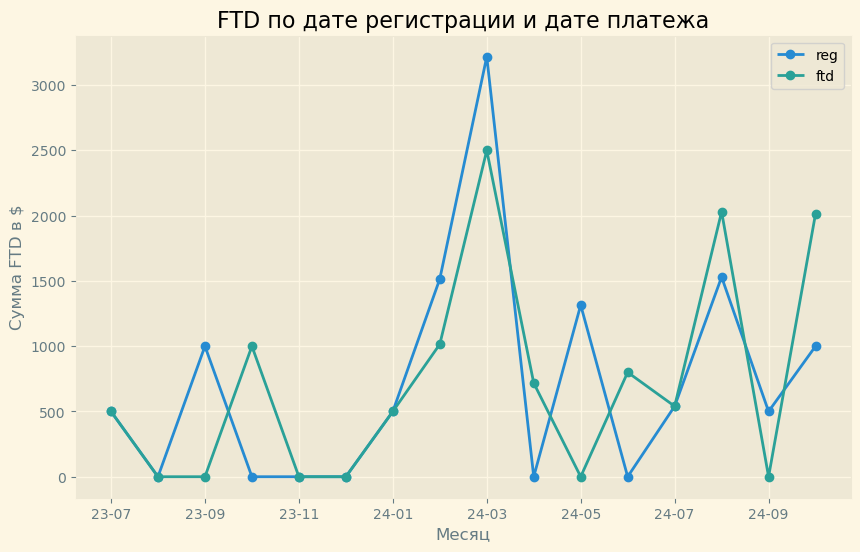

In [22]:
ax = df_full.plot(x='reg_month', y='FTD', marker="o", label='reg', figsize=(10, 6))

df_pay.plot(x='pay_month', y='FTD', marker="o", label='ftd', ax=ax)

plt.title('FTD по дате регистрации и дате платежа')
plt.xlabel('Месяц')
plt.ylabel('Сумма FTD в $');

Нет большой просадки в Сентябре

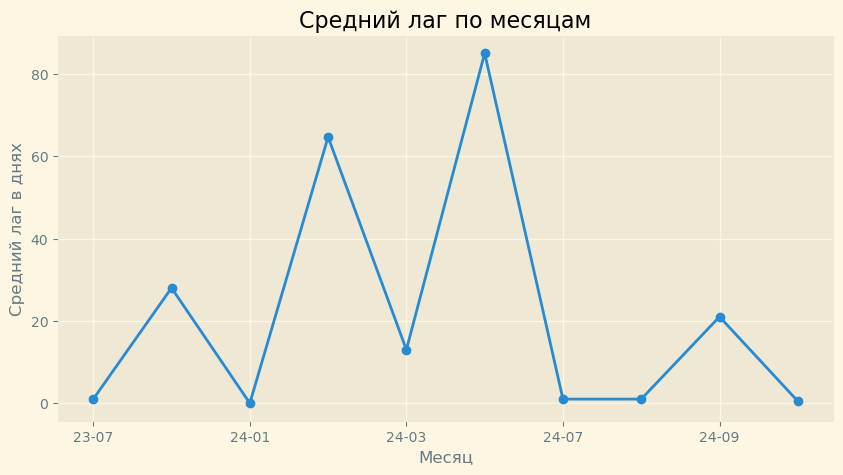

In [23]:
data.groupby('reg_month').lag.mean().plot(figsize=(10, 5), marker="o")

plt.title('Средний лаг по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний лаг в днях');

Средний лаг последние месяцы минимален

#### Страны

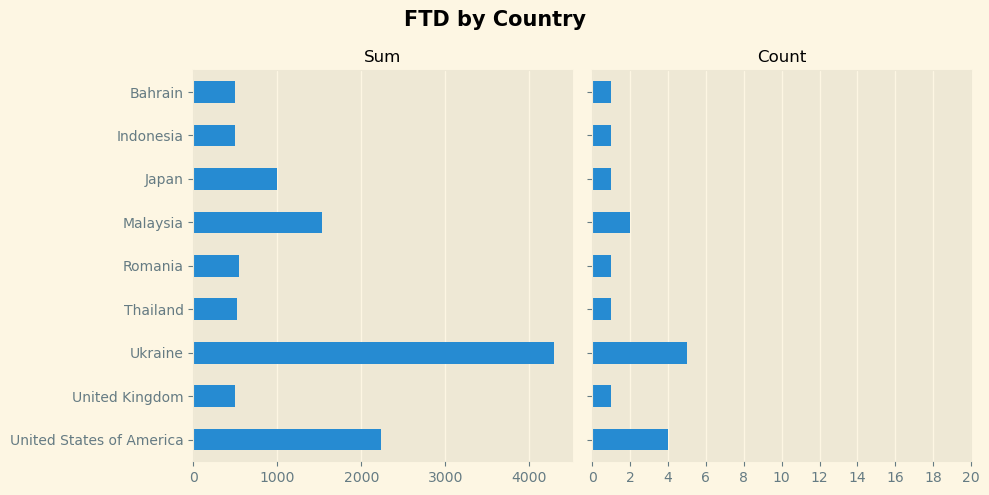

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.suptitle('FTD by Country', fontsize=15, fontweight='bold')

data.groupby('country', as_index=False).FTD.sum().sort_values(by='country', ascending=False).plot(kind='barh', 
                                                                                                          x='country', 
                                                                                                          y='FTD', 
                                                                                                          legend=False, 
                                                                                                          ax=ax1)
ax1.set_title('Sum', fontsize=12)
ax1.grid(axis='y')
ax1.set_ylabel('')

data.groupby('country', as_index=False).FTD.count().sort_values(by='country',
                                                                    ascending=False).plot(kind='barh', 
                                                                                    x='country', 
                                                                                                            y='FTD', 
                                                                                                            legend=False, 
                                                                                                            ax=ax2)
ax2.set_title('Count', fontsize=12)
ax2.set_xticks(range(0, 21, 2))
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

Украина и США в лидерах по количеству клиентов

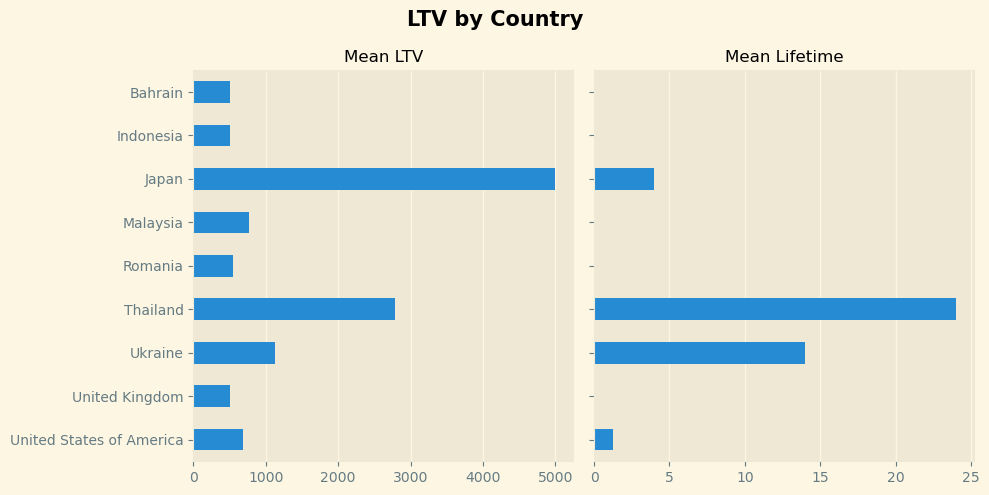

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

plt.suptitle('LTV by Country', fontsize=15, fontweight='bold')

data.groupby('country', as_index=False).LTV.mean().sort_values(by='country', 
                                                                   ascending=False).plot(kind='barh', x='country', y='LTV', legend=False, ax=ax1)
ax1.set_title('Mean LTV', fontsize=12)
ax1.grid(axis='y')
ax1.set_ylabel('')

data.groupby('country', as_index=False).lifetime.mean().sort_values(by='country', 
                                                ascending=False).plot(kind='barh', x='country', y='lifetime', legend=False, ax=ax2)
ax2.set_title('Mean Lifetime', fontsize=12)
ax2.grid(axis='y')

plt.tight_layout()
plt.show()

По пустым строкам на втором графике можно сделать вывод о том, что это было единственное пополнение. С повторными пополнениями клиенты из Японии, Тайланда, США и Украины

#### Тип аккаунта

In [26]:
result = data.groupby('account_type').agg({'FTD':['count', 'mean'], 'LTV':'mean'}).round(2).reset_index()
result.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in result.columns]

In [27]:
print(f'Количество крупных клиентов по типу аккаунта :\n', result)

Количество крупных клиентов по типу аккаунта :
   account_type  FTD count  FTD mean  LTV mean
0      company          6    847.50    847.50
1     personal         11    593.86   1327.05


У кампаний выше FTD, но остаются дольше клиенты

#### Рефки и UTM

In [28]:
data.groupby(['aff_name', 'aff_email']).agg({'FTD':['count', 'mean'], 'LTV':'mean'}).reset_index()

aff_name           aff_email   FTD           LTV
                                 count   mean   mean
0  GoogleAds  GoogleAds@mail.com     6  595.0  595.0

In [29]:
data.groupby(['utm_source', 'utm_medium', 'utm_campaign']).agg({'FTD':['count', 'mean'], 'LTV':'mean'}).reset_index()

utm_source utm_medium       utm_campaign   FTD           LTV
                                           count   mean   mean
0     google        cpc  search-general-ww     2  765.0  765.0
1     google       pmax   pmax|20726836713     1  540.0  540.0

Самая эффективная кампания - _search-general-ww_

In [30]:
from io import BytesIO
import requests
spreadsheet_id = '1TsTsHPkgG-_3fRtzJmWt8jUXfi483p14QR2PozjQqOc'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)

r = requests.get(file_name)
utm = pd.read_excel(BytesIO(r.content), sheet_name='utm_bq')

In [31]:
utm = utm.rename(columns={'User id':'user_id'})

In [32]:
data = data.merge(utm, how='left', on='user_id')

In [33]:
data.groupby(['Acquired Source','Acquired Medium','Acquired Campaign']).agg({'FTD':['count', 'mean'], 'LTV':'mean'}).reset_index()

Acquired Source Acquired Medium            Acquired Campaign   FTD  \
                                                                count   
0         (direct)          (none)                     (direct)     7   
1           google             cpc     Search - General - WW #2     1   
2       newsletter           email  casino-indonesia-case-study     1   
3  zayavochnik.xyz        referral                   (referral)     2   

                       LTV  
         mean         mean  
0  790.357143  1371.214286  
1  500.000000   500.000000  
2  500.000000   500.000000  
3  500.000000   500.000000

#### Краткие выводы

Так как у нас маленькая выборка (14клиентов), и большой разброс значений от месяца к месяцу, мы не видим каких-то закономерностей по крупным FTD, соответственно нам и не стоит ожидать каких-то высоких значений для определенного месяца. Я бы назвал крупный FTD скорее аномалией чем ожидаемым являением

Если резюмировать анализ, можно отметить следующее:
- последние месяцы лаг уменьшился
- лидеры по сумме и количеству FTD такие гео, как Украина и США
- из 14 клиентов только 4 пополнялись более одного раза, при этом лайфтайм не был более месяца
- у нас было 4 кампании и 10 клиентов в выборке - кампании пополняются в среднем чуть выше, но денег (LTV) приносят меньше
- 2 клиенто пришло по рк search-general-ww, 1 - pmax